In [6]:
import pandas as pd
from fullcontact import FullContactClient
import numpy as np
from imblearn.over_sampling import SMOTENC
from helpers import Data
from urllib.request import urlopen, Request
import mysql.connector
from getpass import getpass
from mysql.connector import connect
from bs4 import BeautifulSoup
import requests
import re
from helpers import individualFeatures, Data, Scraping


w = pd.read_csv(r'C:\Users\aacjp\Sales-Scientist\datasets\check6.csv').drop(['Unnamed: 0'], axis='columns')

In [8]:
w.corr()['customer']

customer               1.000000
adspend               -0.119245
hardcosts             -0.181082
revenue               -0.073451
avg_polarity          -0.238770
avg_subjectivity      -0.144778
std_polarity          -0.185070
std_subjectivity      -0.185881
words                  0.208824
triggers               0.165175
links                 -0.202711
percentSocial          0.281868
percentDisplay         0.200405
percentSearchPaid      0.147592
percentSearch         -0.332425
visits                -0.208689
monthlyVisitsChange   -0.076765
bounceRate            -0.123412
global                 0.390428
percentPaid            0.320589
sales                 -0.224379
adRevenue             -0.078879
cac                   -0.025309
roas                   0.126201
profit                 0.021403
profitMargin           0.000291
lpc                   -0.115906
averageOrderValue     -0.062984
Name: customer, dtype: float64

In [8]:
customers = w.loc[w['customer']==1]
x = np.unique(list(customers['model']))
y = []
for model in x:
    y.append(len(customers.loc[customers['model']==model]))

C:\Users\aacjp\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

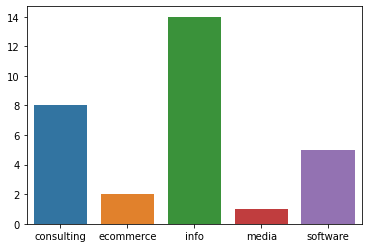

In [9]:
import seaborn as sns

sns.barplot(x, y)

The Hack: http://sangaline.com/post/advanced-web-scraping-tutorial/

In [22]:
(5/22) * 125

28.409090909090907

In [31]:
customers.loc[customers['model']=='software']['name']

0         clickfunnels.com
5           mastermind.com
6            ShopaNova.com
7               SamCart.io
27    rankoneecommerce.com
Name: name, dtype: object